# Impulse Response Function (IRF) - Prosty Przykład

Ten notebook pokazuje prosty przykład analizy IRF (Impulse Response Function) na syntetycznych danych makroekonomicznych.

## 1. Import bibliotek

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

# Ustawienia wyświetlania
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

## 2. Generowanie syntetycznych danych

Symulujemy prosty system ekonomiczny z trzema zmiennymi:
- **PKB** - Produkt Krajowy Brutto
- **Inflacja** - stopa inflacji
- **Stopa_proc** - stopa procentowa banku centralnego

In [2]:
# Parametry symulacji
n_obs = 200  # liczba obserwacji

# Macierz współczynników VAR(1) - jak zmienne wpływają na siebie
A = np.array([
    [0.8, 0.2, -0.1],   # PKB: zależy głównie od poprzedniego PKB
    [0.1, 0.7,  0.15],  # Inflacja: zależy od poprzedniej inflacji
    [0.05, 0.3, 0.85]   # Stopa proc: reaguje na inflację
])

# Macierz wariancji-kowariancji szoków
Sigma = np.array([
    [1.0, 0.2, 0.1],
    [0.2, 0.8, 0.15],
    [0.1, 0.15, 0.6]
])

# Generowanie danych
Y = np.zeros((n_obs, 3))
Y[0] = np.random.multivariate_normal([0, 0, 0], Sigma)

for t in range(1, n_obs):
    epsilon = np.random.multivariate_normal([0, 0, 0], Sigma)
    Y[t] = A @ Y[t-1] + epsilon

# Tworzenie DataFrame
df = pd.DataFrame(Y, columns=['PKB', 'Inflacja', 'Stopa_proc'])

print("Wygenerowano dane:")
print(df.head())
print(f"\nRozmiar danych: {df.shape}")

Wygenerowano dane:
        PKB  Inflacja  Stopa_proc
0 -0.488890 -0.435035    0.303834
1 -1.939342 -0.981180   -0.429858
2 -2.673749 -2.151567   -1.786046
3 -3.100111 -1.927754   -2.603307
4 -3.815858 -0.481078   -3.477733

Rozmiar danych: (200, 3)


## 3. Wizualizacja danych

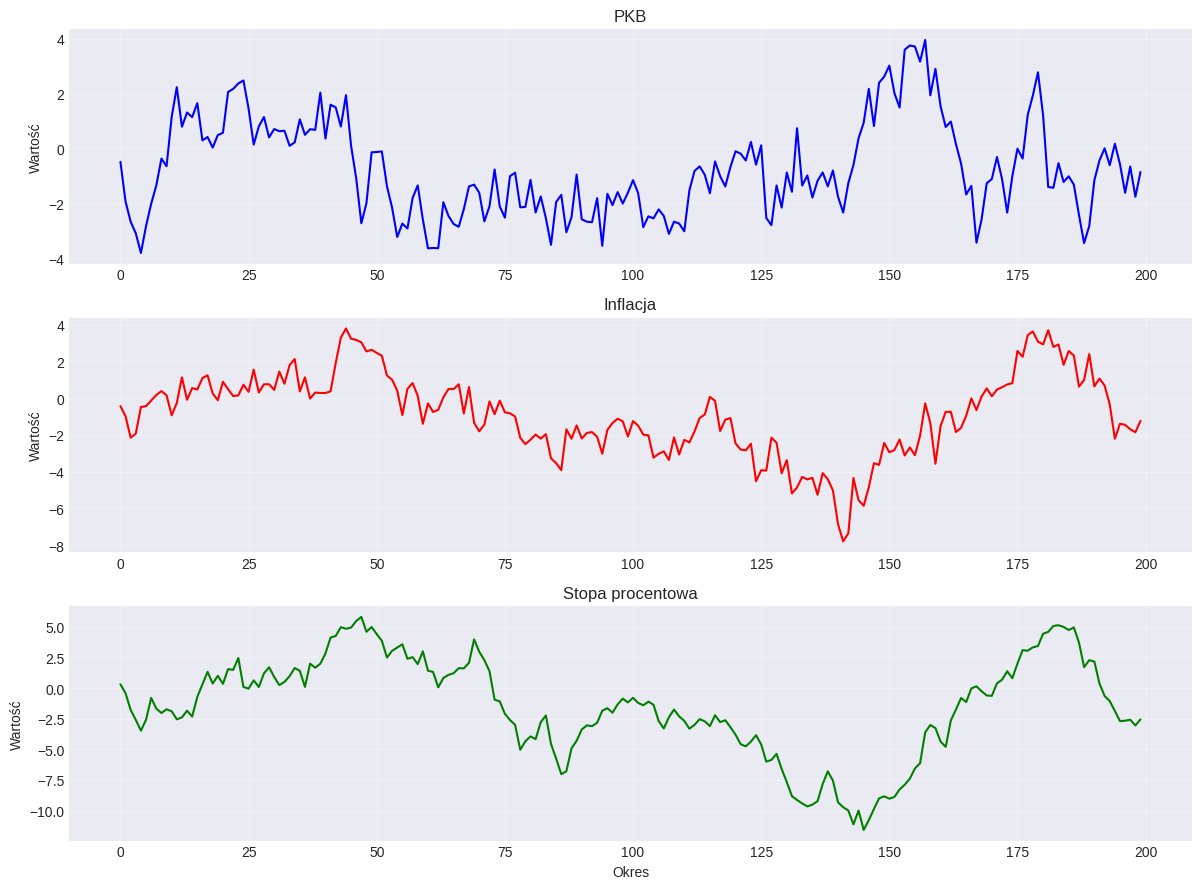

In [3]:
# Wykresy szeregów czasowych
fig, axes = plt.subplots(3, 1, figsize=(12, 9))

df['PKB'].plot(ax=axes[0], title='PKB', color='blue')
axes[0].set_ylabel('Wartość')
axes[0].grid(True, alpha=0.3)

df['Inflacja'].plot(ax=axes[1], title='Inflacja', color='red')
axes[1].set_ylabel('Wartość')
axes[1].grid(True, alpha=0.3)

df['Stopa_proc'].plot(ax=axes[2], title='Stopa procentowa', color='green')
axes[2].set_ylabel('Wartość')
axes[2].set_xlabel('Okres')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Test stacjonarności (ADF)

Przed analizą IRF musimy sprawdzić, czy nasze szeregi są stacjonarne.

In [4]:
print("=== TEST STACJONARNOŚCI (ADF) ===\n")

for col in df.columns:
    result = adfuller(df[col])
    print(f"{col}:")
    print(f"  ADF Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    
    if result[1] < 0.05:
        print(f"  ✓ Szereg jest STACJONARNY (p < 0.05)")
    else:
        print(f"  ✗ Szereg jest NIESTACJONARNY (p >= 0.05)")
    print()

=== TEST STACJONARNOŚCI (ADF) ===

PKB:
  ADF Statistic: -3.4904
  p-value: 0.0082
  ✓ Szereg jest STACJONARNY (p < 0.05)

Inflacja:
  ADF Statistic: -2.3120
  p-value: 0.1681
  ✗ Szereg jest NIESTACJONARNY (p >= 0.05)

Stopa_proc:
  ADF Statistic: -1.7178
  p-value: 0.4220
  ✗ Szereg jest NIESTACJONARNY (p >= 0.05)



## 5. Estymacja modelu VAR

Wybieramy optymalną liczbę opóźnień i estymujemy model VAR.

In [5]:
# Tworzenie modelu VAR
model = VAR(df)

# Wybór optymalnej liczby lagów
lag_order = model.select_order(maxlags=8)
print("=== WYBÓR LICZBY LAGÓW ===\n")
print(lag_order.summary())

# Wybieramy liczbę lagów na podstawie AIC
optimal_lag = lag_order.aic
print(f"\n✓ Optymalna liczba lagów (AIC): {optimal_lag}")

=== WYBÓR LICZBY LAGÓW ===

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       3.900       3.951       49.40       3.921
1     -0.9740    -0.7704*      0.3776    -0.8915*
2    -0.9820*     -0.6257     0.3746*     -0.8377
3     -0.9325     -0.4236      0.3937     -0.7264
4     -0.8687     -0.2071      0.4197     -0.6008
5     -0.8461    -0.03174      0.4296     -0.5163
6     -0.8044      0.1626      0.4482     -0.4128
7     -0.7251      0.3947      0.4858     -0.2716
8     -0.7241      0.5483      0.4869     -0.2088
-------------------------------------------------

✓ Optymalna liczba lagów (AIC): 2


In [6]:
# Estymacja modelu z optymalną liczbą lagów
results = model.fit(optimal_lag)

print(f"=== MODEL VAR({optimal_lag}) ===\n")
print(f"Liczba parametrów: {results.params.size}")
print(f"Log-Likelihood: {results.llf:.2f}")
print(f"AIC: {results.aic:.2f}")
print(f"BIC: {results.bic:.2f}")

=== MODEL VAR(2) ===

Liczba parametrów: 21
Log-Likelihood: -726.28
AIC: -0.97
BIC: -0.62


## 6. Obliczanie IRF (Impulse Response Function)

Teraz obliczamy IRF - jak zmienne reagują na szoki w ciągu 20 okresów.

In [7]:
# Obliczanie IRF dla 20 okresów
irf = results.irf(periods=20)

print("=== IMPULSE RESPONSE FUNCTIONS ===\n")
print("IRF obliczone dla 20 okresów")
print(f"Kształt macierzy IRF: {irf.irfs.shape}")
print("(okresy, zmienne-odpowiedzi, zmienne-impulsy)")

=== IMPULSE RESPONSE FUNCTIONS ===

IRF obliczone dla 20 okresów
Kształt macierzy IRF: (21, 3, 3)
(okresy, zmienne-odpowiedzi, zmienne-impulsy)


## 7. Wizualizacja IRF - Kompletna macierz

Wyświetlamy wszystkie kombinacje impulsów i reakcji.

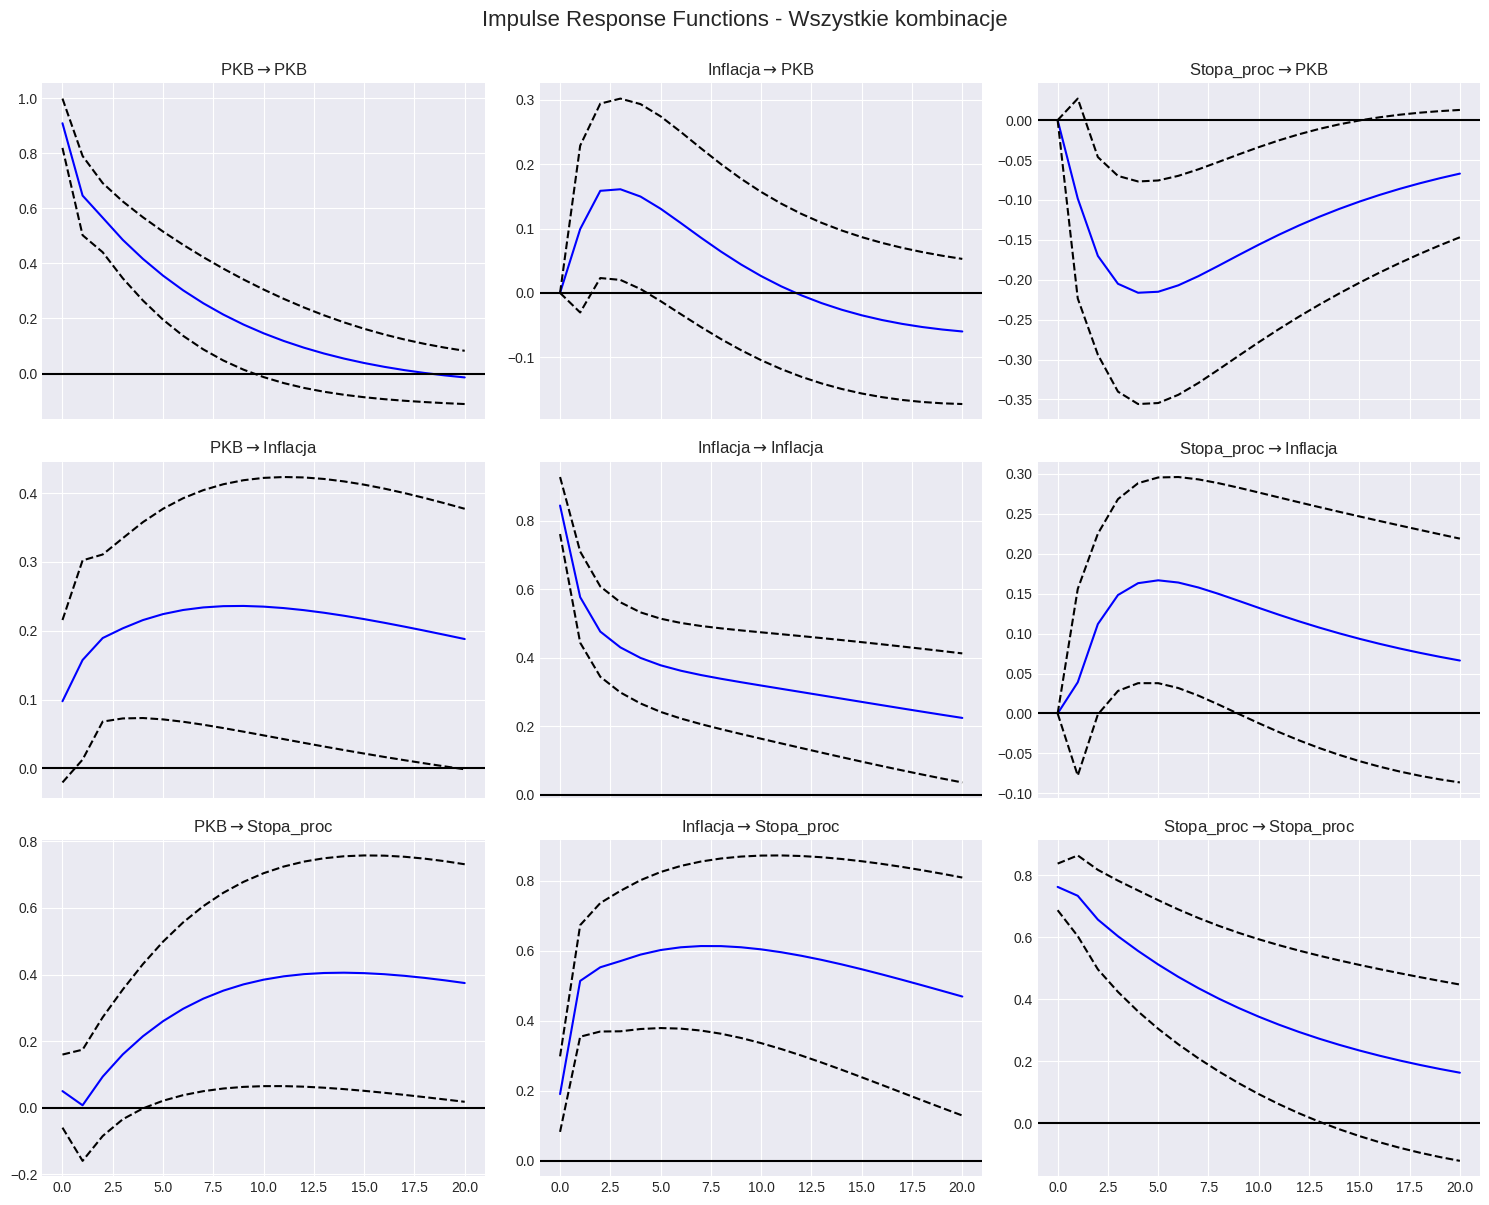

In [8]:
# Kompletna macierz IRF
fig = irf.plot(orth=True, figsize=(15, 12))
plt.suptitle('Impulse Response Functions - Wszystkie kombinacje', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

## 8. Przykład 1: Reakcja PKB na szok w stopie procentowej

**Interpretacja ekonomiczna:** Gdy bank centralny podnosi stopy procentowe, jak reaguje PKB?

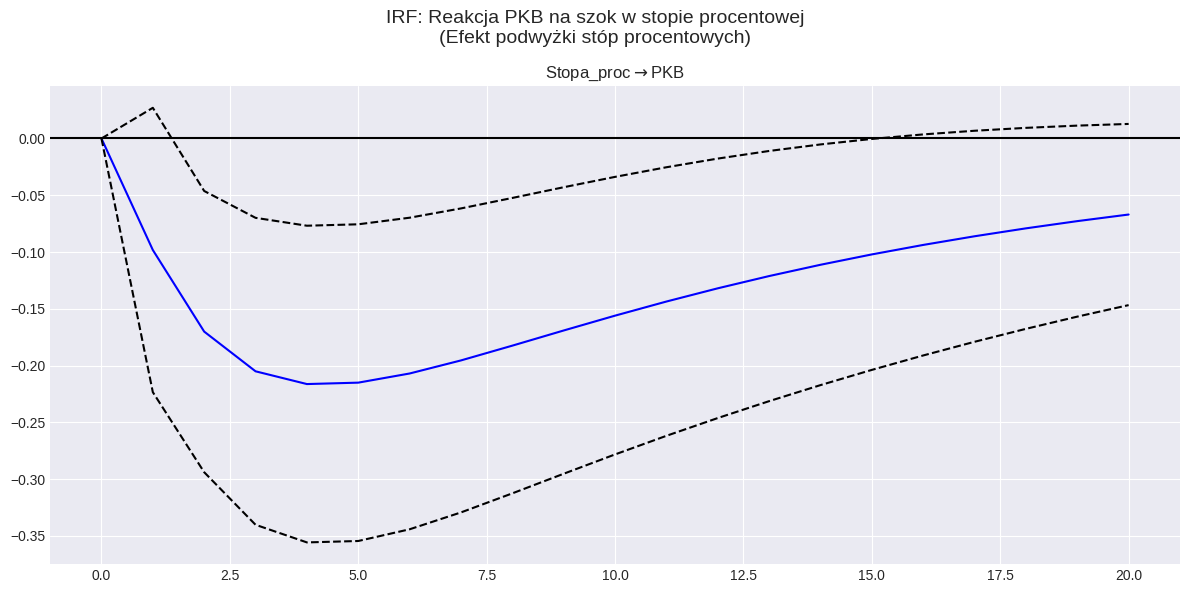


Wartości IRF dla pierwszych 10 okresów:
Okres 0: +0.0000
Okres 1: -0.1287
Okres 2: -0.2229
Okres 3: -0.2687
Okres 4: -0.2834
Okres 5: -0.2818
Okres 6: -0.2712
Okres 7: -0.2561
Okres 8: -0.2391
Okres 9: -0.2216


In [9]:
# IRF: Stopa_proc -> PKB
fig = irf.plot(orth=True, impulse='Stopa_proc', response='PKB', figsize=(12, 6))
plt.suptitle('IRF: Reakcja PKB na szok w stopie procentowej\n(Efekt podwyżki stóp procentowych)', 
             fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

# Wyświetlenie wartości numerycznych
irf_values = irf.irfs[:10, 0, 2]  # PKB (0), Stopa_proc (2)
print("\nWartości IRF dla pierwszych 10 okresów:")
for i, val in enumerate(irf_values):
    print(f"Okres {i}: {val:+.4f}")

## 9. Przykład 2: Reakcja inflacji na szok w PKB

**Interpretacja ekonomiczna:** Gdy PKB rośnie, jak reaguje inflacja?

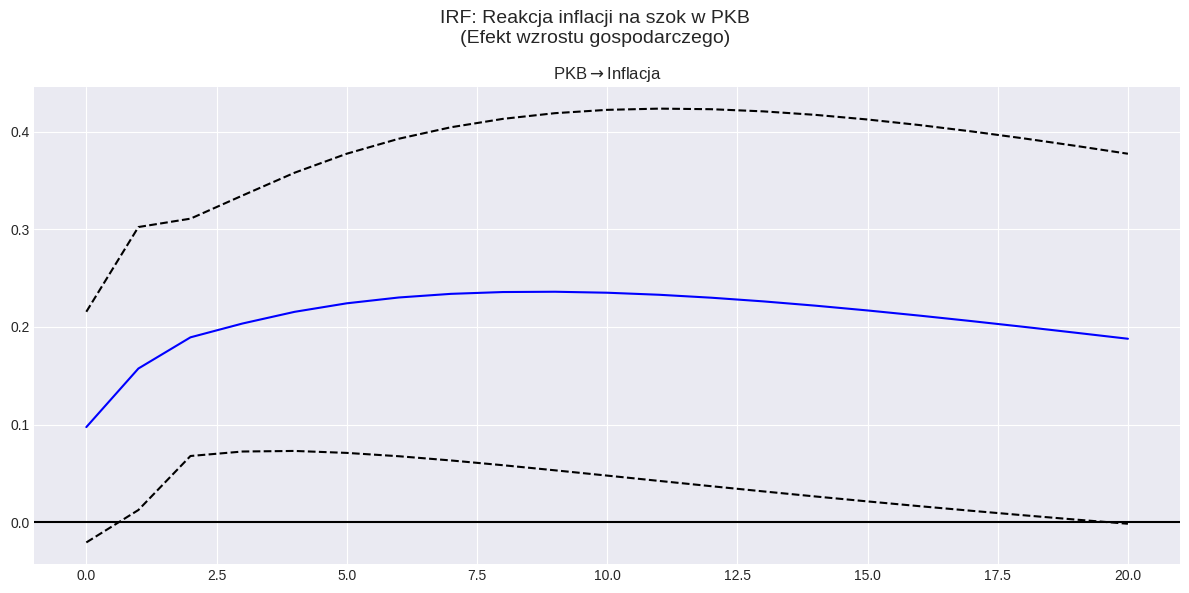


Wartości IRF dla pierwszych 10 okresów:
Okres 0: +0.0000
Okres 1: +0.0983
Okres 2: +0.1432
Okres 3: +0.1632
Okres 4: +0.1796
Okres 5: +0.1918
Okres 6: +0.2005
Okres 7: +0.2064
Okres 8: +0.2102
Okres 9: +0.2121


In [10]:
# IRF: PKB -> Inflacja
fig = irf.plot(orth=True, impulse='PKB', response='Inflacja', figsize=(12, 6))
plt.suptitle('IRF: Reakcja inflacji na szok w PKB\n(Efekt wzrostu gospodarczego)', 
             fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

# Wyświetlenie wartości numerycznych
irf_values = irf.irfs[:10, 1, 0]  # Inflacja (1), PKB (0)
print("\nWartości IRF dla pierwszych 10 okresów:")
for i, val in enumerate(irf_values):
    print(f"Okres {i}: {val:+.4f}")

## 10. Przykład 3: Reakcja stopy procentowej na szok inflacyjny

**Interpretacja ekonomiczna:** Jak bank centralny reaguje na wzrost inflacji?

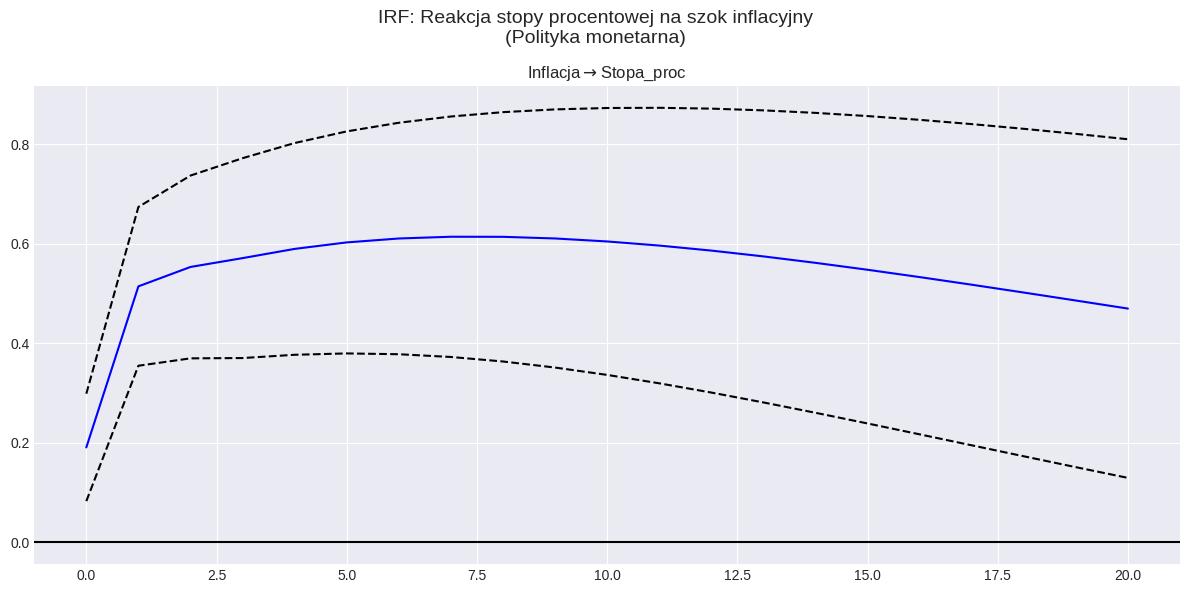


Wartości IRF dla pierwszych 10 okresów:
Okres 0: +0.0000
Okres 1: +0.3917
Okres 2: +0.4605
Okres 3: +0.4975
Okres 4: +0.5334
Okres 5: +0.5618
Okres 6: +0.5830
Okres 7: +0.5979
Okres 8: +0.6076
Okres 9: +0.6128


In [11]:
# IRF: Inflacja -> Stopa_proc
fig = irf.plot(orth=True, impulse='Inflacja', response='Stopa_proc', figsize=(12, 6))
plt.suptitle('IRF: Reakcja stopy procentowej na szok inflacyjny\n(Polityka monetarna)', 
             fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

# Wyświetlenie wartości numerycznych
irf_values = irf.irfs[:10, 2, 1]  # Stopa_proc (2), Inflacja (1)
print("\nWartości IRF dla pierwszych 10 okresów:")
for i, val in enumerate(irf_values):
    print(f"Okres {i}: {val:+.4f}")

## 11. Analiza właściwości IRF

In [12]:
def analyze_irf_simple(irf_results, impulse_var, response_var):
    """
    Prosta analiza właściwości IRF
    """
    var_names = ['PKB', 'Inflacja', 'Stopa_proc']
    impulse_idx = var_names.index(impulse_var)
    response_idx = var_names.index(response_var)
    
    irf_values = irf_results.irfs[:, response_idx, impulse_idx]
    
    # Analiza
    max_response = np.max(np.abs(irf_values))
    max_period = np.argmax(np.abs(irf_values))
    cumulative_effect = np.sum(irf_values)
    initial_response = irf_values[0]
    
    print(f"\n=== ANALIZA: {impulse_var} → {response_var} ===")
    print(f"Reakcja początkowa (okres 0): {initial_response:+.4f}")
    print(f"Maksymalna reakcja: {max_response:.4f} w okresie {max_period}")
    print(f"Efekt kumulatywny (suma): {cumulative_effect:+.4f}")
    print(f"Reakcja po 10 okresach: {irf_values[10]:+.4f}")
    print(f"Reakcja po 19 okresach: {irf_values[19]:+.4f}")
    
    # Interpretacja
    if initial_response > 0:
        print(f"\n💡 Interpretacja: Szok w {impulse_var} powoduje WZROST {response_var}")
    else:
        print(f"\n💡 Interpretacja: Szok w {impulse_var} powoduje SPADEK {response_var}")

# Analiza wybranych relacji
analyze_irf_simple(irf, 'Stopa_proc', 'PKB')
analyze_irf_simple(irf, 'PKB', 'Inflacja')
analyze_irf_simple(irf, 'Inflacja', 'Stopa_proc')


=== ANALIZA: Stopa_proc → PKB ===
Reakcja początkowa (okres 0): +0.0000
Maksymalna reakcja: 0.2834 w okresie 4
Efekt kumulatywny (suma): -3.6996
Reakcja po 10 okresach: -0.2044
Reakcja po 19 okresach: -0.0954

💡 Interpretacja: Szok w Stopa_proc powoduje SPADEK PKB

=== ANALIZA: PKB → Inflacja ===
Reakcja początkowa (okres 0): +0.0000
Maksymalna reakcja: 0.2126 w okresie 10
Efekt kumulatywny (suma): +3.7818
Reakcja po 10 okresach: +0.2126
Reakcja po 19 okresach: +0.1809

💡 Interpretacja: Szok w PKB powoduje SPADEK Inflacja

=== ANALIZA: Inflacja → Stopa_proc ===
Reakcja początkowa (okres 0): +0.0000
Maksymalna reakcja: 0.6140 w okresie 10
Efekt kumulatywny (suma): +11.1360
Reakcja po 10 okresach: +0.6140
Reakcja po 19 okresach: +0.5234

💡 Interpretacja: Szok w Inflacja powoduje SPADEK Stopa_proc


## 12. IRF z przedziałami ufności

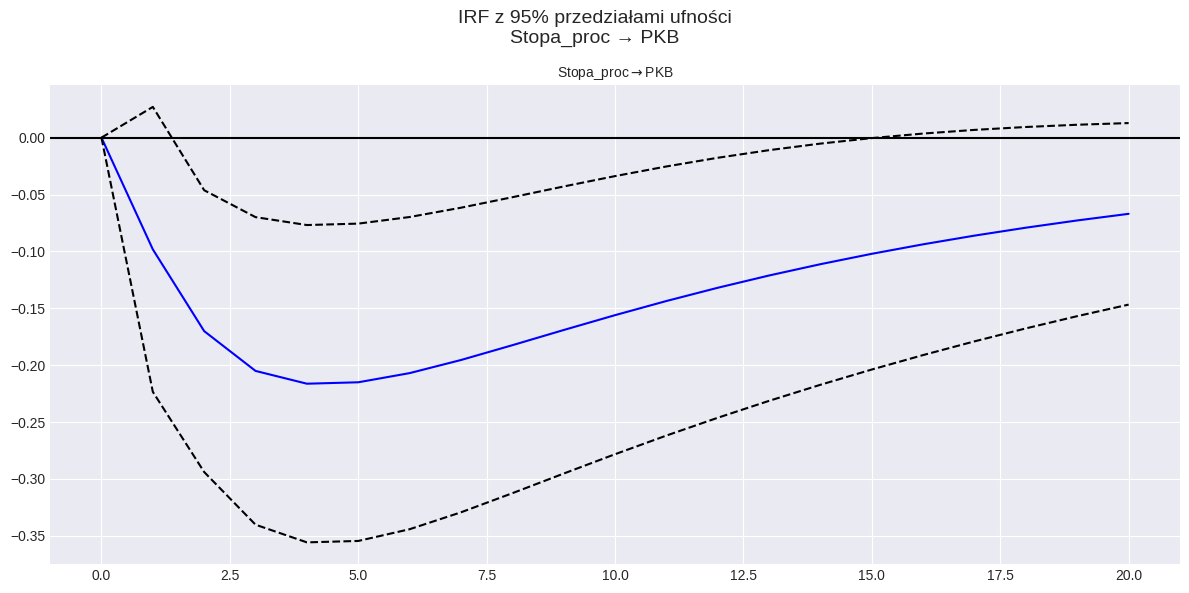


💡 Szare obszary pokazują 95% przedziały ufności
   Jeśli przedział obejmuje zero, reakcja jest statystycznie nieistotna


In [13]:
# IRF z przedziałami ufności dla wybranej relacji
fig = irf.plot(orth=True, impulse='Stopa_proc', response='PKB',
               figsize=(12, 6), subplot_params={'fontsize': 10})
plt.suptitle('IRF z 95% przedziałami ufności\nStopa_proc → PKB', 
             fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

print("\n💡 Szare obszary pokazują 95% przedziały ufności")
print("   Jeśli przedział obejmuje zero, reakcja jest statystycznie nieistotna")

## 13. Forecast Error Variance Decomposition (FEVD)

FEVD pokazuje, jaki procent wariancji każdej zmiennej jest wyjaśniany przez szoki w innych zmiennych.

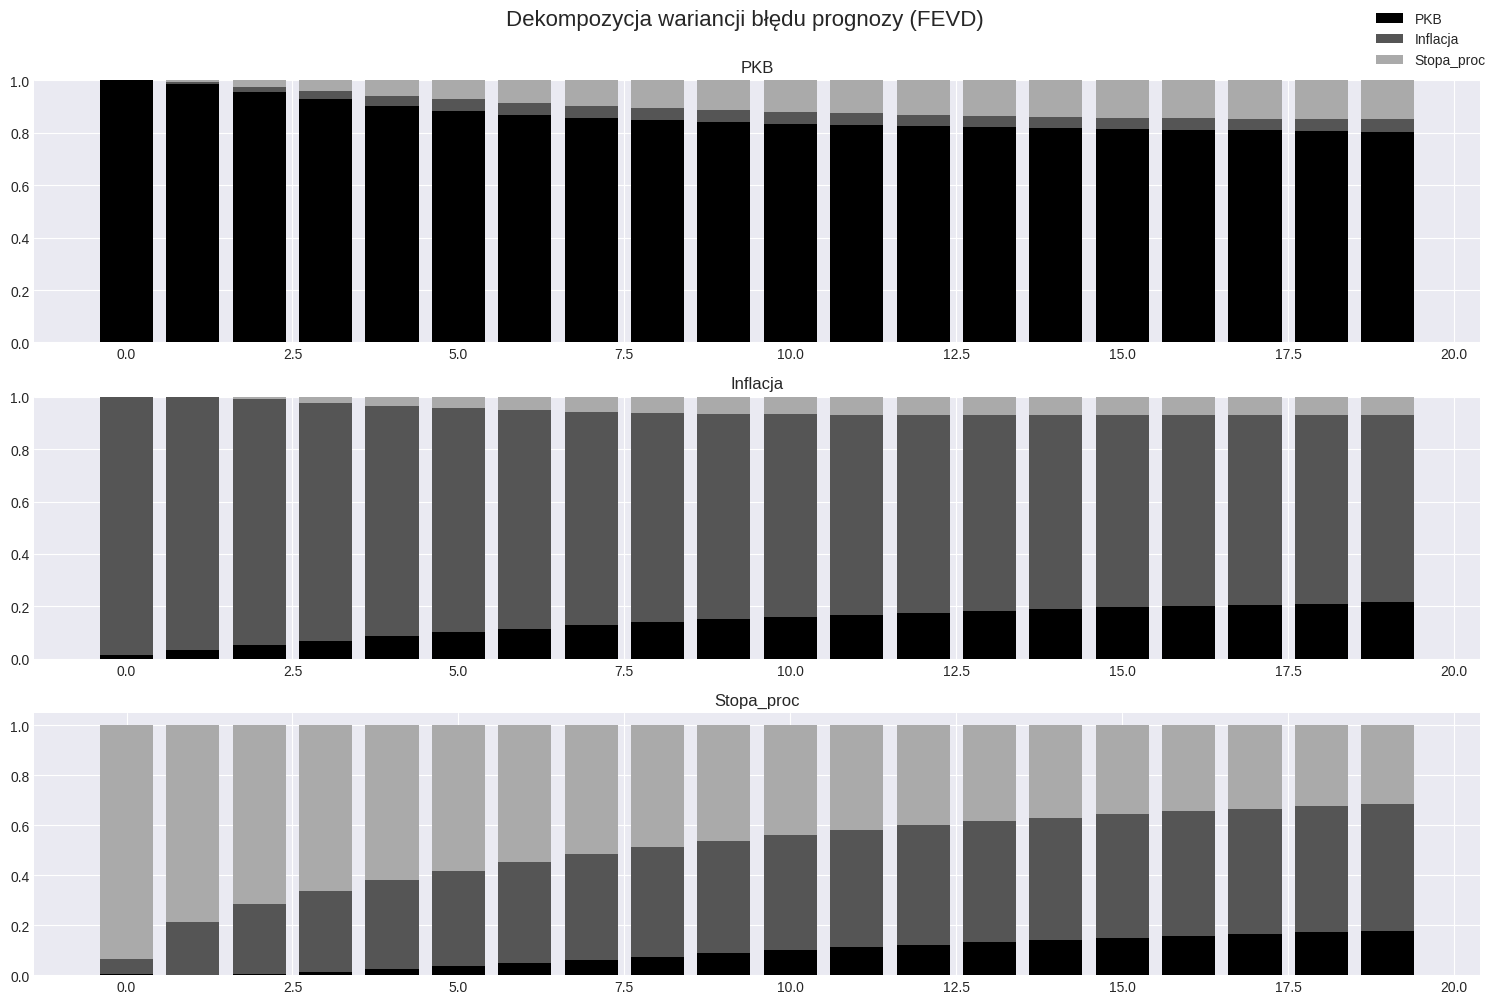


💡 FEVD pokazuje, jak zmienne wpływają na siebie w czasie
   100% = cała wariancja zmiennej jest wyjaśniana przez kombinację szoków


In [14]:
# Obliczanie FEVD
fevd = results.fevd(periods=20)

# Wizualizacja
fig = fevd.plot(figsize=(15, 10))
plt.suptitle('Dekompozycja wariancji błędu prognozy (FEVD)', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

print("\n💡 FEVD pokazuje, jak zmienne wpływają na siebie w czasie")
print("   100% = cała wariancja zmiennej jest wyjaśniana przez kombinację szoków")

## 14. Podsumowanie

### Czego się nauczyliśmy:

1. **IRF (Impulse Response Function)** pokazuje, jak zmienne reagują w czasie na jednorazowy szok

2. **Typowe relacje ekonomiczne:**
   - Wzrost stóp procentowych → spadek PKB (polityka restrykcyjna)
   - Wzrost PKB → wzrost inflacji (przegrzanie gospodarki)
   - Wzrost inflacji → wzrost stóp procentowych (reakcja banku centralnego)

3. **Horyzont czasowy** - efekty szoków zanikają w czasie (powrót do równowagi)

4. **Przedziały ufności** - pozwalają ocenić statystyczną istotność reakcji

5. **FEVD** - uzupełnia IRF, pokazując względny wpływ różnych szoków